In [1]:
from robot_vlp.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, FIGURES_DIR, MODELS_DIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import robot_vlp.stats.navigation_performance as nav
import robot_vlp.modeling.EKF as ekf
import robot_vlp.data_collection.communication as c
import robot_vlp.data_collection.experment_processing as ep

from tensorflow.keras.models import load_model
import robot_vlp.data.preprocessing as p

# Load the model (automatically detects format)
model = load_model(MODELS_DIR / 'navigation_neural_nets/rnn.keras')  # or 'path/to/model.h5'

%load_ext autoreload
%autoreload 2


2025-04-23 15:51:17.294 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp
2025-04-23 15:51:20.599361: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-23 15:51:20.599387: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-23 15:51:20.599392: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-23 15:51:20.599433: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 15:51:20.599444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Import models

In [4]:
rnn_mod = load_model(MODELS_DIR / 'navigation_neural_nets/rnn.keras') 


def vec_to_ang(pre_ang):
    return np.arctan2(pre_ang[:,0], pre_ang[:,1]) * 180/ np.pi

def normalize_angle_deg(angle):
    """Normalize an angle in degrees to the range [-180, 180]."""
    return (angle + 180) % 360 - 180

def preprocess_df(df):
    X = df[['vlp_x_hist', 'vlp_y_hist','vlp_heading_hist','vlp_heading_change', 'encoder_heading_change', 'encoder_heading_hist', 'encoder_x_hist','encoder_y_hist']].values
    y = df[['x_hist', 'y_hist','heading_hist']].values
    X_win, y_win, m_win = p.window_data(X, y, y, overlap = 0.999999, window_len = 20)
    return X_win, y_win, m_win
    


test_file = INTERIM_DATA_DIR / 'exp_vive_navigated_paths'/'exp1_9_high_acc.csv'
df = pd.read_csv(test_file)
X_win, y_win, m_win = preprocess_df(df)
X_win = np.nan_to_num(X_win, nan = 0)
y_win = np.nan_to_num(y_win, nan = 0)

In [5]:
df_lst = []
for i in range(10):
    test_file = INTERIM_DATA_DIR / 'exp_vive_navigated_paths'/f'exp1_{i}_high_acc.csv'
    df = pd.read_csv(test_file)
    df_lst.append(df)

err_stats = ekf.calc_err_stats(df_lst[:-1])
ekf_df = ekf.run_ekf(df_lst[-1].iloc[:].reset_index(drop = True),err_stats)
ekf_df = ekf_df.iloc[19:].reset_index(drop = True)


ekf_pre_loc = ekf_df[['EKF_x', 'EKF_y']].values
ekf_pre_degrees  = ekf_df['EKF_heading_rad'].values * 180/ np.pi

ekf_loc_errs = nav.calc_loc_err(ekf_pre_loc, y_win[:,:2])
ekf_ang_errs = ekf_pre_degrees - y_win[:,2]
ekf_ang_errs = np.array([normalize_angle_deg(ang) for ang in ekf_ang_errs])

In [6]:
pre_loc, pre_ang = rnn_mod.predict(X_win)
rnn_loc_errs = nav.calc_loc_err(pre_loc, y_win[:,:2])
rnn_ang_errs = vec_to_ang(pre_ang) - y_win[:,2]
rnn_ang_errs = np.array([normalize_angle_deg(ang) for ang in rnn_ang_errs])

vlp_ang_errs = y_win[:,2] -  X_win[:,-1,2]
vlp_ang_errs = np.array([normalize_angle_deg(ang) for ang in vlp_ang_errs])



encoder_ang_ers =  X_win[:,-1,5]- y_win[:,2]
encoder_ang_ers = abs(np.array([normalize_angle_deg(ang) for ang in encoder_ang_ers]))

encoder_loc_errs = nav.calc_loc_err(X_win[:,-1,-2:], y_win[:,:2])

vlp_loc_errs = nav.calc_loc_err(X_win[:,-1,:2], y_win[:,:2])

print(f"vlp pos errs:{vlp_loc_errs.mean()}")
print(f"encoder pos errs:{encoder_loc_errs.mean()}")
print(f"RNN pos errs:{rnn_loc_errs.mean()}")
print(f"ekf pos errs:{ekf_loc_errs.mean()}")
print(f"VLP heading errs:{np.abs(vlp_ang_errs).mean()}")
print(f"encoder heading errs:{np.abs(encoder_ang_ers).mean()}")
print(f"RNN heading errs:{np.abs(rnn_ang_errs).mean()}")
print(f"ekf heading errs:{np.abs(ekf_ang_errs).mean()}")

2025-04-23 15:51:52.498488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
vlp pos errs:0.03564608240868678
encoder pos errs:0.053852080143880585
RNN pos errs:0.10122315392140983
ekf pos errs:0.035643858900960626
VLP heading errs:9.960864515836017
encoder heading errs:14.5345812269169
RNN heading errs:4.237742388999707
ekf heading errs:4.317178300825763


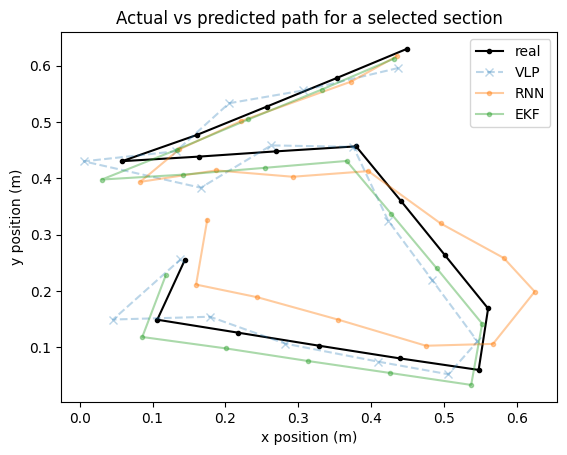

In [7]:
s = 10

e = s+ 17

plt.plot(ekf_df['x_hist'].iloc[s:e], ekf_df['y_hist'].iloc[s:e], label = 'real', marker = '.', c = 'k')

plt.plot(ekf_df['vlp_x_hist'].iloc[s:e], ekf_df['vlp_y_hist'].iloc[s:e], label = 'VLP', marker = 'x', linestyle = '--', alpha = 0.3)

plt.plot(pre_loc[s:e,0],pre_loc[s:e,1], label = 'RNN', marker = '.', alpha = 0.4)

plt.plot(ekf_df.iloc[s:e]['EKF_x'], ekf_df.iloc[s:e]['EKF_y'], label = 'EKF', marker = '.', alpha = 0.4)


plt.legend()
plt.title('Actual vs predicted path for a selected section')
plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.savefig(FIGURES_DIR/'model_training_performance_demonstration.png')


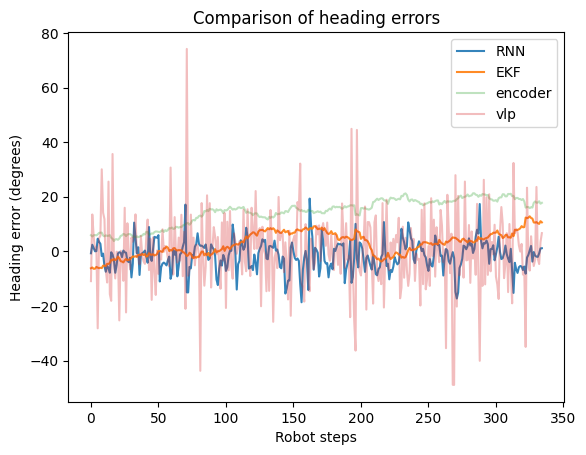

In [8]:
plt.plot(rnn_ang_errs, label = 'RNN', alpha = 0.9)
plt.plot(ekf_ang_errs, label = 'EKF', alpha = 0.9)

plt.plot(encoder_ang_ers, label = 'encoder', alpha = 0.3)
plt.plot(vlp_ang_errs, label = 'vlp', alpha = 0.3)
plt.legend()

plt.title('Comparison of heading errors')
plt.xlabel('Robot steps')
plt.ylabel('Heading error (degrees)')

plt.savefig(FIGURES_DIR/'model_training_performance_all_heading.png')

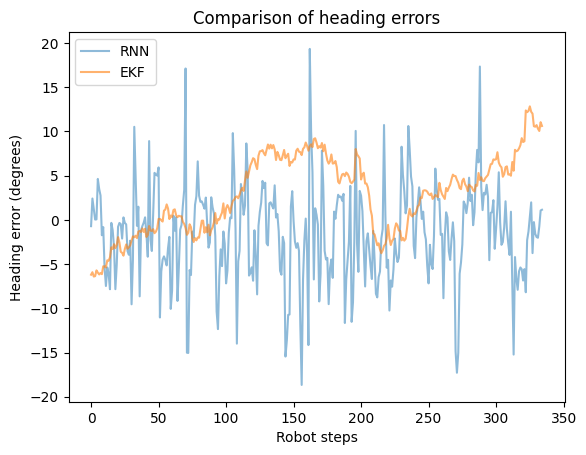

In [9]:
plt.plot(rnn_ang_errs, label = 'RNN', alpha = 0.5)
plt.plot(ekf_ang_errs, label = 'EKF', alpha = 0.6)


plt.legend()

plt.title('Comparison of heading errors')
plt.xlabel('Robot steps')
plt.ylabel('Heading error (degrees)')
plt.savefig(FIGURES_DIR/'model_training_performance_model_heading.png')

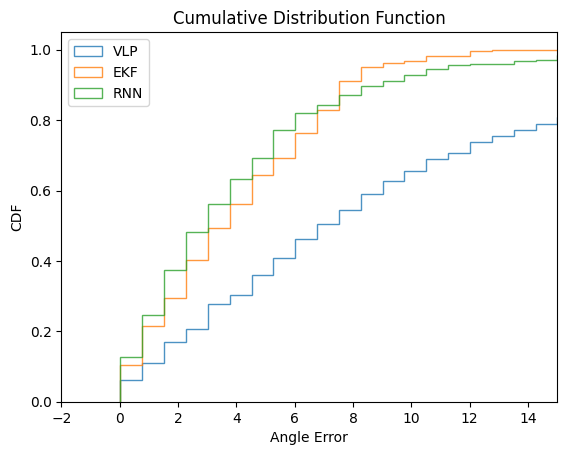

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Combine data to define common bins
all_data = abs(np.concatenate((vlp_ang_errs, ekf_ang_errs, rnn_ang_errs)))
bins = np.linspace(all_data.min(), all_data.max(), 100)

plt.hist(abs(vlp_ang_errs), bins=bins, density=True, histtype='step', cumulative=True, label='VLP', alpha=0.8)
plt.hist(abs(ekf_ang_errs), bins=bins, density=True, histtype='step', cumulative=True, label='EKF', alpha=0.8)
plt.hist(abs(rnn_ang_errs), bins=bins, density=True, histtype='step', cumulative=True, label='RNN', alpha=0.8)

plt.xlim(-2,15)

plt.xlabel('Angle Error')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function')
plt.legend(loc='upper left')


plt.savefig(FIGURES_DIR/'model_training_performance_heading_cdf.png')

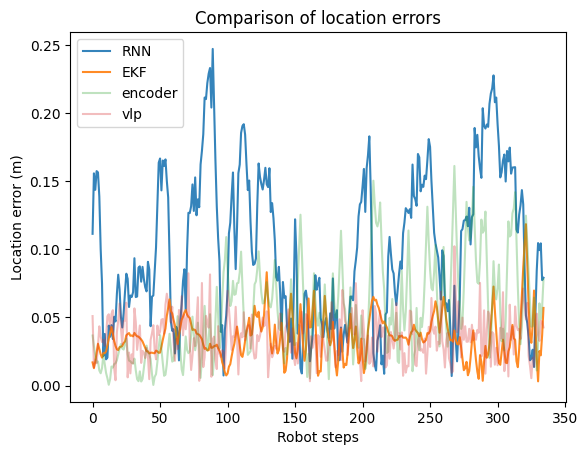

In [11]:
plt.plot(rnn_loc_errs, label = 'RNN', alpha = 0.9)
plt.plot(ekf_loc_errs, label = 'EKF', alpha = 0.9)

plt.plot(encoder_loc_errs, label = 'encoder', alpha = 0.3)
plt.plot(vlp_loc_errs, label = 'vlp', alpha = 0.3)
plt.legend()

plt.title('Comparison of location errors')
plt.xlabel('Robot steps')
plt.ylabel('Location error (m)')

plt.savefig(FIGURES_DIR/'model_training_performance_all_location.png')

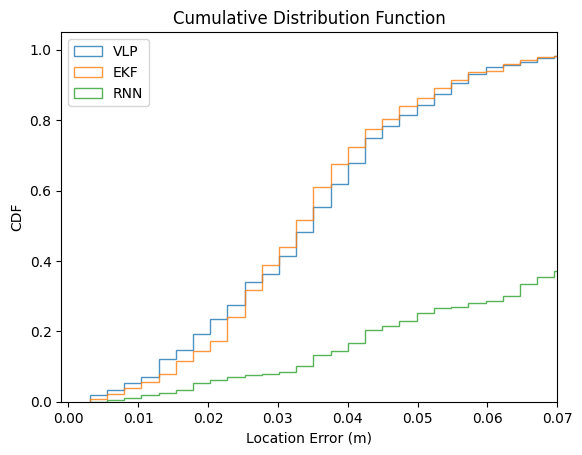

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Combine data to define common bins
all_data = abs(np.concatenate((vlp_loc_errs, ekf_loc_errs, rnn_loc_errs)))
bins = np.linspace(all_data.min(), all_data.max(), 100)

plt.hist(abs(vlp_loc_errs), bins=bins, density=True, histtype='step', cumulative=True, label='VLP', alpha=0.8)
plt.hist(abs(ekf_loc_errs), bins=bins, density=True, histtype='step', cumulative=True, label='EKF', alpha=0.8)
plt.hist(abs(rnn_loc_errs), bins=bins, density=True, histtype='step', cumulative=True, label='RNN', alpha=0.8)

plt.xlim(-0.001,0.07)

plt.xlabel('Location Error (m)')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function')
plt.legend(loc='upper left')


plt.savefig(FIGURES_DIR/'model_training_performance_location_cdf.png')
